# Libraries

In [1]:
import psutil
psutil.virtual_memory() 

svmem(total=540408950784, available=524044996608, percent=3.0, used=11710545920, free=525524094976, active=1490685952, inactive=3881127936, buffers=3833856, cached=3170476032, shared=1643581440, slab=1617727488)

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp

import scipy.linalg as sc
import numpy.linalg as lin

In [3]:
from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import klus.algorithms as al
import klus.kernels as kernels
# import d3s.tools as tools
# import d3s.domain as domain

In [5]:
import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

import cftime

# Definition of functions

## Definition order_w

In [ ]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [ ]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion  (spatial correlation)
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [ ]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [ ]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [ ]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

In [6]:
def eigenfunction_value_opt(cc, KK_tot, x, mode):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    ntime = KK_tot.ntime
    PsiX = KK_tot.PsiX
    mode_cc = cc[:, mode]  # Extract the mode component once

    # Precompute k(x, PsiX) to avoid redundant calculations
    k_values = np.array([k(x, PsiX[:, i]) for i in range(ntime)])

    f = np.dot(mode_cc, k_values)  # Use NumPy dot product for summation
    return f

## Definition sigma cost function

In [ ]:
from scipy.optimize import minimize_scalar

In [ ]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Load and regrid data

In [6]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

In [7]:
ds_tos

<xarray.DataArray (time: 24000, lat: 180, lon: 360)>
[1555200000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
Attributes:
    regrid_method:  bilinear

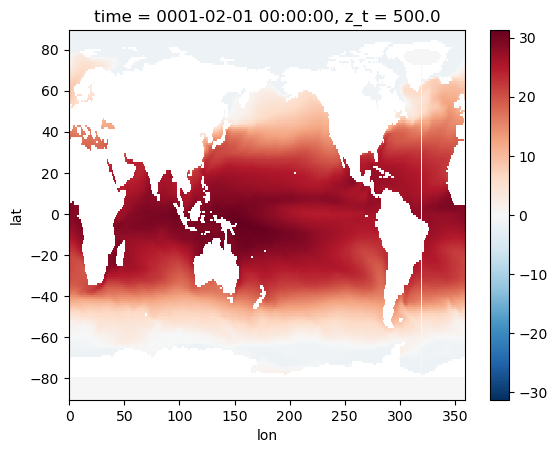

In [8]:
ds_tos.isel(time=0).plot()

## Subset data

In [34]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [10]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

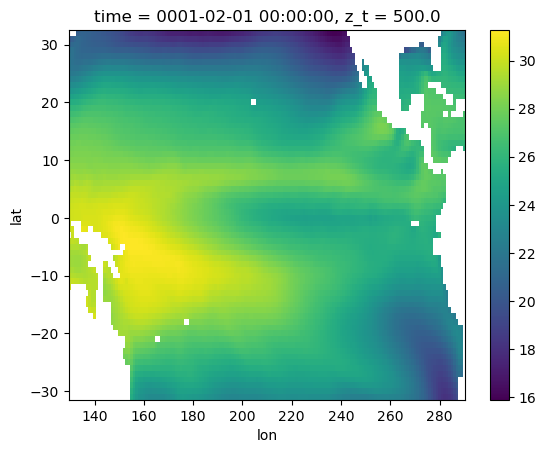

In [11]:
S_tos.isel(time=0).plot()

In [12]:
del(ds_tos, ds_ssh)

In [13]:
import psutil
psutil.virtual_memory() 

svmem(total=540408950784, available=523791167488, percent=3.1, used=11930836992, free=525236781056, active=1555361792, inactive=4103634944, buffers=3833856, cached=3237498880, shared=1643585536, slab=1618333696)

## Create matrices, de-trending data and anomalies

In [14]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [15]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [16]:
del(S_tos,S_ssh)

In [17]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [18]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

In [19]:
X_tos

 
 Math Data Matrix 
 <xarray.DataArray (z: 9121, time: 24000)>
array([[ 0.39702395, -0.6189652 , -0.85483867, ...,  0.01754726,
         0.4485007 ,  0.45266727],
       [ 0.1696403 , -0.8670136 , -0.82748204, ..., -0.18566637,
         0.30663636,  0.0749752 ],
       [ 0.04911598, -0.8939764 , -0.6554643 , ..., -0.32772142,
         0.22505376, -0.1466265 ],
       ...,
       [ 0.39432192,  0.8016582 ,  0.8832131 , ..., -0.28593224,
        -0.38302863, -0.2468319 ],
       [ 0.2645133 ,  0.6563553 ,  0.84212416, ..., -0.36678267,
        -0.34379554, -0.21504594],
       [ 0.13001835,  0.5547301 ,  0.77214986, ..., -0.3915147 ,
        -0.32304496, -0.17562436]], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
    

# Compute general EOFs

In [35]:
##################################################################
############# SELECT DATA AND COMPUTE EOFs #######################
##################################################################
X_tos_sel=X_tos.A
X_ssh_sel=X_ssh.A


## Compute EOFs
### SST
xdat = X_tos_sel.data
if encode_svd:
    udatx, sdatx, vhdatx = sc.svd(xdat[:,:], full_matrices=False)

    if not var_retained:
        mr=lin.matrix_rank(xdat)
        print(f'  Number of SVD modes set to Rank {mr}')
    else:
        mr = np.min(np.where(np.cumsum(sdatx**2/sum(sdatx**2)) > var_retained -0.001))
        print(f'  Number of SVD modes retained {mr}')
    var = sdatx**2
    print(f'Variance Retained {sum(sdatx[0:mr]**2)/sum(var):.4f}')

#mr = lin.matrix_rank(xdat)    
mr = 20
var = sdatx**2
print(sum(sdatx[0:mr]**2)/sum(var))

#Standardize Coefficients and Reduce dimensionality via an EOF encoding
#keep only mr modes
udat_sst=udatx[:,0:mr]
sdat_sst=sdatx[0:mr]
# the columns of vhdatx contain the coefficients of the field (standardized to unit variance)
vhdat_sst=vhdatx[0:mr,:]
# coffieints non standardized directly from projection on EOF
vdat_sst=udat_sst.T.conj() @ xdat

### SSH
xdat = X_ssh_sel.data
if encode_svd:
    udatx, sdatx, vhdatx = sc.svd(xdat[:,:], full_matrices=False)

    if not var_retained:
        mr=lin.matrix_rank(xdat)
        print(f'  Number of SVD modes set to Rank {mr}')
    else:
        mr = np.min(np.where(np.cumsum(sdatx**2/sum(sdatx**2)) > var_retained -0.001))
        print(f'  Number of SVD modes retained {mr}')
    var = sdatx**2
    print(f'Variance Retained {sum(sdatx[0:mr]**2)/sum(var):.4f}')

mr = lin.matrix_rank(xdat)     #31
var = sdatx**2
print(sum(sdatx[0:mr]**2)/sum(var))

#Standardize Coefficients and Reduce dimensionality via an EOF encoding
#keep only mr modes
udat_ssh=udatx[:,0:mr]
sdat_ssh=sdatx[0:mr]
# the columns of vhdatx contain the coefficients of the field (standardized to unit variance)
vhdat_ssh=vhdatx[0:mr,:]
# coffieints non standardized directly from projection on EOF
vdat_ssh=udat_ssh.T.conj() @ xdat


  Number of SVD modes set to Rank 845
Variance Retained 0.9989
0.8355839632749511
  Number of SVD modes set to Rank 1077
Variance Retained 0.9992
0.9992372336185688


In [ ]:
#Choose number of EOFs for each variable
nEOF_SST= 845
nEOF_D20= 1000
nEOF_WS= 0

#insert nº of EOFs retained, limit of the training period, tau0 and number of lags
nEOF= nEOF_SST + nEOF_D20 + nEOF_WS     #23

In [ ]:
# Select just X first EOFs
data_SST= vdat_sst[0:nEOF_SST,:]
data_SSH= vdat_ssh[0:nEOF_D20,:]

EOFs_SST= udat_sst[:,0:nEOF_SST]
EOFs_SSH= udat_ssh[:,0:nEOF_D20]

PCs=np.concatenate((data_SST,data_SSH), axis=0)
EOFs_sst_ssh=np.concatenate((EOFs_SST,EOFs_SSH), axis=1)

PCs=PCs.astype('float64')
print(PCs.shape)
print(EOFs_sst_ssh.shape)

In [ ]:
np.save('Processed_data/PCs_CESM_20SST_10SSH', PCs, allow_pickle=True, fix_imports=True)
np.save('Processed_data/EOFs_CESM_20SST_10SSH', EOFs_sst_ssh, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('Processed_data/PCs_CESM_845SST_1000SSH', PCs, allow_pickle=True, fix_imports=True)
np.save('Processed_data/EOFs_CESM_845SST_1000SSH', EOFs_sst_ssh, allow_pickle=True, fix_imports=True)

In [ ]:
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [ ]:
print(PCs.shape)
print(EOFs.shape)

# Compute optimal stds and Giannakis optimization

In [ ]:
PCs=np.load('Processed_data/PCs_CESM_20SST_10SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_20SST_10SSH.npy')

In [ ]:
giann= np.zeros([2,20])
giann.shape

In [ ]:
chunks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
chunks

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
options = {'operator': 'Koopman', 
               'kernel_choice': 'gauss',
               'bandwidth': 'std',
               'epsilon': 1e-5}

In [ ]:
PCs.shape

In [ ]:
encode_svd=True
for m in chunks:

    ##################################################################
    ############# SELECT DATA AND COMPUTE EOFs #######################
    ##################################################################
    nchunk=chunks[m]
    print(nchunk)
    
    ##################################################################
    #############         SIGMA AND STD         ######################
    ##################################################################

    PCs_sel=PCs[:,nchunk*1200:1200+nchunk*1200]
    
    # Sigma optimization
    KK_tot=zkop.Koop(PCs_sel,**options)

    #result = minimize_scalar(cost, bounds=(10,150), method='Bounded',options={'disp':3,'xatol':0.001})
    #giann[0,m]=result.x
    
    # Std
    similarity=distance.squareform(distance.pdist(KK_tot.PsiX.T ,'sqeuclidean'))
    scale=np.std(similarity.flatten())
    std=np.sqrt(scale/2)
    giann[0,m]=std
    
    ##################################################################
    #############         GIANNAKIS          ######################
    ##################################################################

    if encode_svd:
        nbrs = NearestNeighbors(n_neighbors=PCs_sel.shape[1], algorithm='auto', radius=10).fit(PCs_sel.T)
        distances, _ = nbrs.kneighbors(PCs_sel.T)
    else:
        nbrs = NearestNeighbors(n_neighbors=xdat.shape[1], algorithm='auto', radius=10).fit(xdat.T)
        distances, _ = nbrs.kneighbors(xdat.T)

    # Compute bandwidth according to Giannakis paper

    nn=np.mean(distances)/np.sqrt(2.)
    print(f' Giannakis {nn*2}, our paper {2*42**2}, equivalent sigma to giannakis {np.sqrt(nn**2/2)}'  )
    giann[1,m]=np.sqrt(nn**2/2)

In [ ]:
np.save('Processed_data/stds_giann_100_30EOFs', giann, allow_pickle=True, fix_imports=True)
#np.save('Processed_data/stds_giann_100_ALLEOFs', giann, allow_pickle=True, fix_imports=True)

# Compute 20 Gram matrices

In [7]:
encode_svd=True

In [8]:
PCs=np.load('Processed_data/PCs_CESM_20SST_10SSH.npy')
sig=np.load('Processed_data/stds_giann_100_30EOFs.npy')
#EOFs=np.load('Processed_data/EOFs_CESM_20SST_10SSH.npy')
sig

array([[ 93.92169863,  90.74941267,  95.57085161,  85.89155872,
         88.44491823, 100.39123986,  90.56996597,  81.83153122,
         92.98262197,  88.70057989,  92.39564315,  92.57396192,
         86.37603794,  87.70898446,  91.56364195, 102.0955315 ,
         87.44955303,  90.07982196,  85.78521033,  94.34046872],
       [ 80.61909321,  77.28596733,  80.48925158,  75.91177601,
         77.39431409,  80.60780582,  77.34711231,  75.59949428,
         76.902306  ,  77.13250827,  79.20128704,  79.41600965,
         76.53976329,  76.96282605,  79.3040024 ,  84.88129084,
         76.70405456,  78.41371873,  76.24614376,  80.79316491]])

In [9]:
chunks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
chunks

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

## Compute them inmediately

In [10]:
for m in chunks:
    
    nchunk=chunks[m]
    print(nchunk)

    ##################################################################
    #############    FITTING KOOPMAN OPERATOR   ######################
    ##################################################################
    
    PCs_sel=PCs[:,nchunk*1200:1200+nchunk*1200]

    # Creating Koopman operator
    options = {'operator': 'Koopman', 
               'kernel_choice': 'gauss',
               'bandwidth': 'std',
               'epsilon': 1e-5}    #, 'time_data': X_tos_sel.time.data[:-1]
    if encode_svd:
         globals()[f'KK_{nchunk}']=zkop.Koop(PCs_sel,**options)
    else:
        globals()[f'KK_{nchunk}']=zkop.Koop(xdat,**options)

    globals()[f'KK_{nchunk}'].fit(bandwidth=sig[1,m], condition=1e-5)

    # Saving needed variables

    globals()[f'Gxx_{nchunk}']=globals()[f'KK_{nchunk}'].Gxx
    globals()[f'Gxy_{nchunk}']=globals()[f'KK_{nchunk}'].Gxy
    
    PsiX=globals()[f'KK_{nchunk}'].PsiX
    Gxx=globals()[f'KK_{nchunk}'].Gxx

    ww=globals()[f'KK_{nchunk}'].ww
    vv=globals()[f'KK_{nchunk}'].vv
 
    globals()[f'cc_{nchunk}']=globals()[f'KK_{nchunk}'].cc

    ##################################################################
    ##########            COMPUTING MODES         ##################
    ##################################################################

    globals()[f'ds_{nchunk}'] = globals()[f'KK_{nchunk}'].compute_modes(ww,vv,modetype='',description='')
    globals()[f'modes_{nchunk}']=globals()[f'ds_{nchunk}'].kmodes.data

0
Created Koopman Estimator 
 for 1199 samples and 30 features,             1 time interval
 Calculating Koopman Operator 
Using option 80.61909321416101 for a  12998.876381347165 and sigma 80.61909321416101

Computed Transfer Eigenvalues
Computed Kmodes (1199, 30) for (1199, 1199) normalized eigenfunctions
Computed Kmodes 1199 30 vv  1199 1199 eigenfunctions
Rank of V matrix 1199
1
Created Koopman Estimator 
 for 1199 samples and 30 features,             1 time interval
 Calculating Koopman Operator 
Using option 77.28596733235378 for a  11946.24149299531 and sigma 77.28596733235378

Computed Transfer Eigenvalues
Computed Kmodes (1199, 30) for (1199, 1199) normalized eigenfunctions
Computed Kmodes 1199 30 vv  1199 1199 eigenfunctions
Rank of V matrix 1199
2
Created Koopman Estimator 
 for 1199 samples and 30 features,             1 time interval
 Calculating Koopman Operator 
Using option 80.48925158349809 for a  12957.039240943299 and sigma 80.48925158349809

Computed Transfer Eigenv

In [11]:
ccs = [cc_0, cc_1, cc_2, cc_3, cc_4, cc_5, cc_6, cc_7, cc_8, cc_9, cc_10, cc_11, cc_12, cc_13, cc_14, cc_15, cc_16, cc_17, cc_18, cc_19]
KKs = [KK_0, KK_1, KK_2, KK_3, KK_4, KK_5, KK_6, KK_7, KK_8, KK_9, KK_10, KK_11, KK_12, KK_13, KK_14, KK_15, KK_16, KK_17, KK_18, KK_19]
dss = [ds_0, ds_1, ds_2, ds_3, ds_4, ds_5, ds_6, ds_7, ds_8, ds_9, ds_10, ds_11, ds_12, ds_13, ds_14, ds_15, ds_16, ds_17, ds_18, ds_19]
modess = [modes_0, modes_1, modes_2, modes_3, modes_4, modes_5, modes_6, modes_7, modes_8, modes_9, modes_10, modes_11, modes_12, modes_13, modes_14, modes_15, modes_16, modes_17, modes_18, modes_19]

In [12]:
del(Gxx_0, Gxx_1, Gxx_2, Gxx_3, Gxx_4, Gxx_5, Gxx_6, Gxx_7, Gxx_8, Gxx_9, Gxx_10, Gxx_11, Gxx_12, Gxx_13, Gxx_14, Gxx_15, Gxx_16, Gxx_17, Gxx_18, Gxx_19)
del(Gxy_0, Gxy_1, Gxy_2, Gxy_3, Gxy_4, Gxy_5, Gxy_6, Gxy_7, Gxy_8, Gxy_9, Gxy_10, Gxy_11, Gxy_12, Gxy_13, Gxy_14, Gxy_15, Gxy_16, Gxy_17, Gxy_18, Gxy_19)
del(cc_0, cc_1, cc_2, cc_3, cc_4, cc_5, cc_6, cc_7, cc_8, cc_9, cc_10, cc_11, cc_12, cc_13, cc_14, cc_15, cc_16, cc_17, cc_18, cc_19)
del(KK_0, KK_1, KK_2, KK_3, KK_4, KK_5, KK_6, KK_7, KK_8, KK_9, KK_10, KK_11, KK_12, KK_13, KK_14, KK_15, KK_16, KK_17, KK_18, KK_19)
del(ds_0, ds_1, ds_2, ds_3, ds_4, ds_5, ds_6, ds_7, ds_8, ds_9, ds_10, ds_11, ds_12, ds_13, ds_14, ds_15, ds_16, ds_17, ds_18, ds_19)
del(modes_0, modes_1, modes_2, modes_3, modes_4, modes_5, modes_6, modes_7, modes_8, modes_9, modes_10, modes_11, modes_12, modes_13, modes_14, modes_15, modes_16, modes_17, modes_18, modes_19)

In [13]:
ccs=np.array(ccs)
KKs=np.array(KKs)
modess=np.array(modess)

In [1]:
pwd

'/work/csp/pl19523'

## Compute them and save them

In [10]:
for m in chunks:
    
    nchunk=chunks[m]
    print(nchunk)

    ##################################################################
    #############    FITTING KOOPMAN OPERATOR   ######################
    ##################################################################
    
    PCs_sel=PCs[:,nchunk*1200:1200+nchunk*1200]

    # Creating Koopman operator
    options = {'operator': 'Koopman', 
               'kernel_choice': 'gauss',
               'bandwidth': 'std',
               'epsilon': 1e-5, 'maxeig':5000}    #, 'time_data': X_tos_sel.time.data[:-1]
    if encode_svd:
        KK=zkop.Koop(PCs_sel,**options)
    else:
        KK=zkop.Koop(xdat,**options)

    KK.fit(bandwidth=sig[1,m])     #CAREFUL HERE: WITHOUT CONDITION REGULARIZATION
    PsiX=KK.PsiX
    ww=KK.ww
    vv=KK.vv
    cc=KK.cc

    ##################################################################
    ##########            COMPUTING MODES         ##################
    ##################################################################

    ds = KK.compute_modes(ww,vv,modetype='',description='')
    modes=ds.kmodes.data

    ##################################################################
    ##########            SAVE VARIABLES         ##################
    ##################################################################

    np.save(f'Processed_data/100 yrs Koopman Operators/noreg_G30_cc_{nchunk}', cc, allow_pickle=True, fix_imports=True)
    np.save(f'Processed_data/100 yrs Koopman Operators/noreg_G30_modes_{nchunk}', modes, allow_pickle=True, fix_imports=True)
    np.save(f'Processed_data/100 yrs Koopman Operators/noreg_G30_eigvals_{nchunk}', ds.eigval, allow_pickle=True, fix_imports=True)

0
Created Koopman Estimator 
 for 1199 samples and 30 features,             1 time interval
 Calculating Koopman Operator 
Using option 80.61909321416101 for a  12998.876381347165 and sigma 80.61909321416101

Computed Transfer Eigenvalues
Computed Kmodes (1199, 30) for (1199, 1199) normalized eigenfunctions
Computed Kmodes 1199 30 vv  1199 1199 eigenfunctions
Rank of V matrix 1199
1
Created Koopman Estimator 
 for 1199 samples and 30 features,             1 time interval
 Calculating Koopman Operator 
Using option 77.28596733235378 for a  11946.24149299531 and sigma 77.28596733235378

Computed Transfer Eigenvalues
Computed Kmodes (1199, 30) for (1199, 1199) normalized eigenfunctions
Computed Kmodes 1199 30 vv  1199 1199 eigenfunctions
Rank of V matrix 1199
2
Created Koopman Estimator 
 for 1199 samples and 30 features,             1 time interval
 Calculating Koopman Operator 
Using option 80.48925158349809 for a  12957.039240943299 and sigma 80.48925158349809

Computed Transfer Eigenv

# Computhe phis

In [14]:
chunks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
chunks

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [15]:
# Select period we want to forecast and operator we want to use 
m=7
op=0        #Either KK_syn or a number from 0 to 20

In [16]:
#Choosing forecasting elements
if op=='KK_syn':
    
    cc= KK_syn.cc
    KK= KK_syn
    ds= A_ds
    modes= A_ds.kmodes
    
elif ((op>= 0) or (op<= 19)):
    cc= ccs[op]
    KK= KKs[op]
    #ds= dss[op]
    #modes= modess[op]

In [17]:
tstep=1
cases=range(0,PCs_sel.shape[1])
nmode=1199        #modes.shape[1]
phix=np.zeros([nmode,len(cases)],dtype='complex')

In [ ]:
%%time
for i in cases:
    
    nstart=i+(1200*m)
    x0=PCs[:,nstart]
    
    #Compute Phix
    for l in range(0,nmode):
        phix[l,i]= eigenfunction_value_opt(cc, KK, x0,l)

    print(i)

In [19]:
np.save('Phix/Phix_30EOFs_p7_o0', phix, allow_pickle=True, fix_imports=True)

# Forecasts

In [20]:
# load_for=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
#load_for=[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
#load_for=[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
#load_for=[0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]   #m=3
#load_for=[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]   #m=4
#load_for=[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19]   #m=5
#load_for=[0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19]   #m=6
load_for=[0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19]   #m=7
#load_for=[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]   #m=8



phix_tot=np.zeros((19, 1199, 1200), dtype=complex)


for n in range(len(load_for)):
    i=load_for[n]
    phix_tot[n,:,:]= np.load(f'Phix/Phix_30EOFs_p7_o{i}.npy')

In [21]:
chunks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
chunks

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [22]:
tstep=1
tim_level=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
cases=range(0,PCs_sel.shape[1]-24)
nmode=modess[0].shape[1]
forecast=np.zeros([19,PCs_sel.shape[0],24,len(cases)])

In [ ]:
%%time
for n in range(len(load_for)):
    c=load_for[n]

    op=c         #Either KK_syn or a number from 0 to 20
    cc= ccs[op]
    KK= KKs[op]
    ds= dss[op]
    modes= modess[op]
    
    for i in cases:

        nstart=i
        phix = phix_tot[n,:,i]
        eigvals=np.diag(ds.eigval[:nmode]**(tstep)) 
        ht=np.zeros([PCs.shape[0],24],dtype='complex')

        #Evolution
        for j in tim_level:
            eigvals=np.diag(ds.eigval**(j*tstep))                   
            ht[:,j]=modes @ eigvals @ phix

        forecast[n,:,:,i]=ht
        print(c,i)

In [24]:
np.save('Forecasts/30EOFs_forecast_p7', forecast, allow_pickle=True, fix_imports=True)

# Evaluation

In [31]:
PCs=np.load('Processed_data/PCs_CESM_20SST_10SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_20SST_10SSH.npy')

In [32]:
tot_for=np.load('Forecasts 100/30EOFs_forecast_p0.npy')

In [33]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

## Leads

In [34]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

In [35]:
tot_for.shape

(19, 30, 24, 1176)

In [36]:
mean_av=np.zeros(24)
mean_ind=np.zeros((24,19))

In [37]:
Jrmse_mean_av=np.zeros(24)
Jrmse_mean_ind=np.zeros((24,19))

In [38]:
#Select period
m=0
udat_sst=EOFs[:,0:20]
X_tos_sel=X_tos.A[:,m*1200:1200+m*1200]

In [39]:
## Compute observations NON truncated to PCs
Xindex=X_tos_sel.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))[:-1]

In [40]:
import nc_time_axis

0.9745623170299155
0.9712767633800027
0.7457888232660101
0.7361747051873139


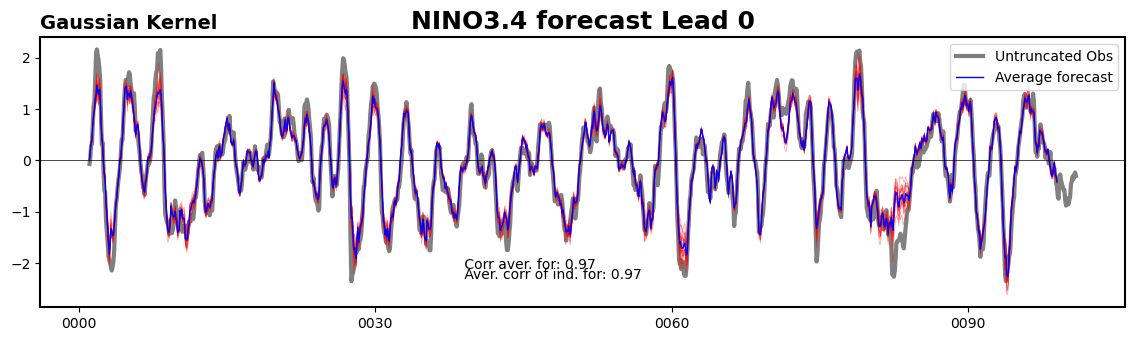

0.9626261485055667
0.9450737555941732
0.6877591933978362
0.648921603910924


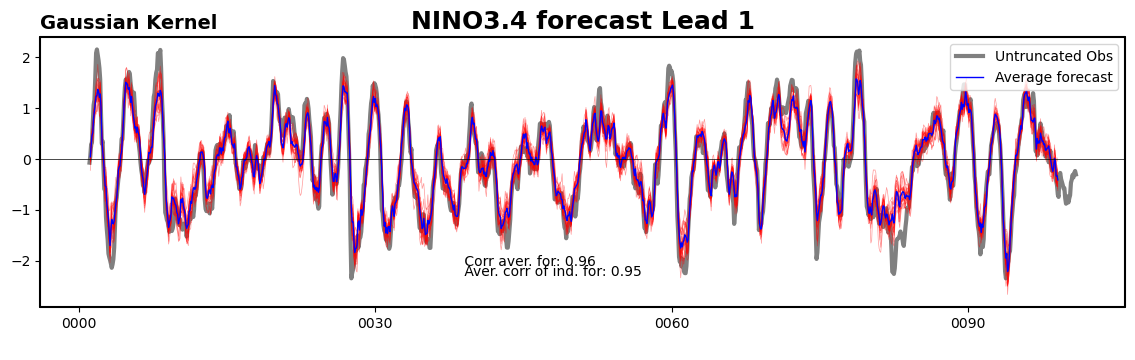

0.9437394957798289
0.9141853932716736
0.632263706492848
0.5789190343212117


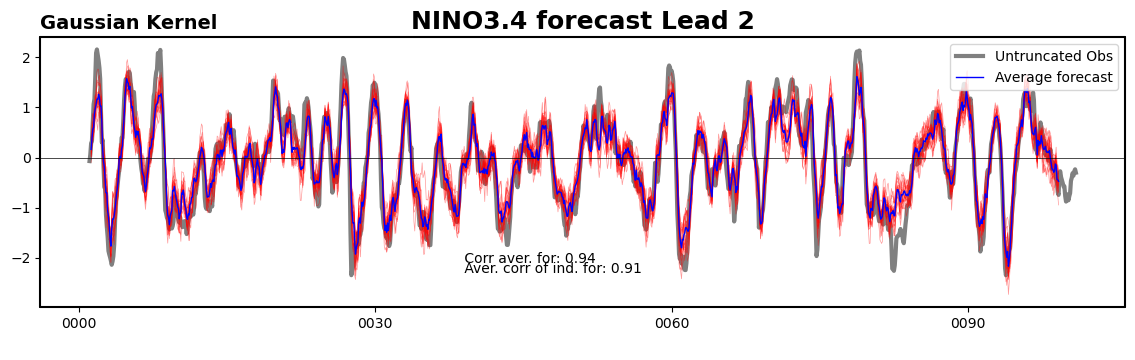

0.9182177231207912
0.87317446204479
0.5684524796430975
0.5024072643526976


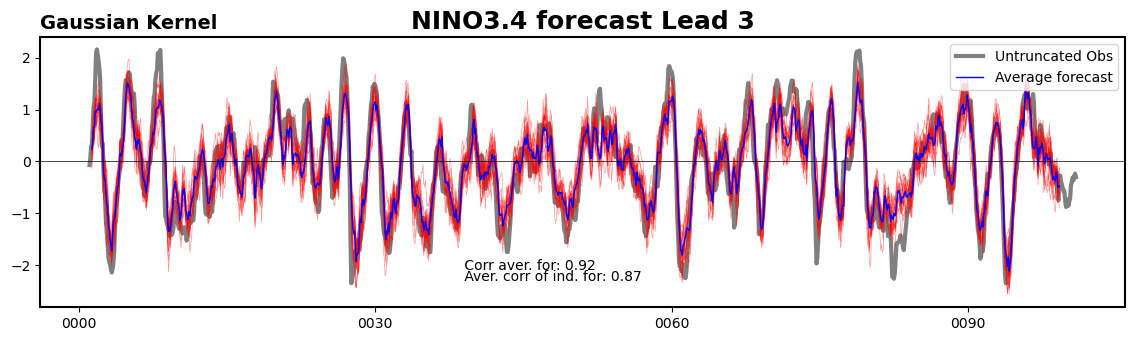

0.8855960910757119
0.8209820554928088
0.5027628586231748
0.42266397176180937


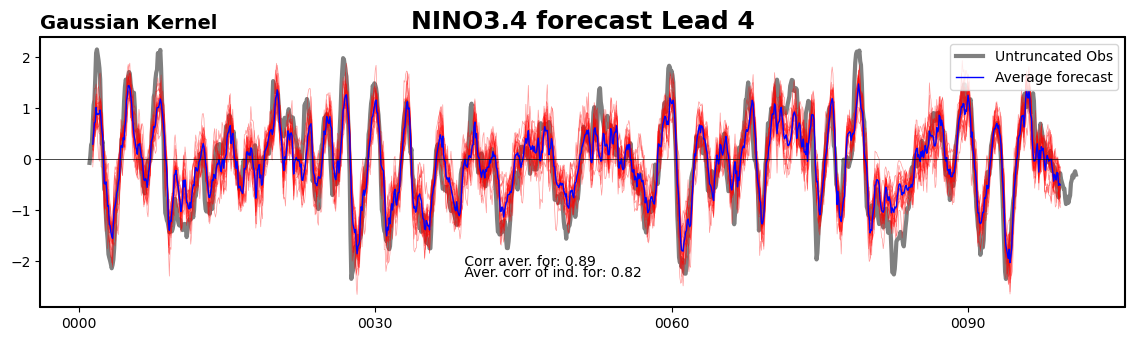

0.8505451806260121
0.7666491439846242
0.4449158616130059
0.35272160125925545


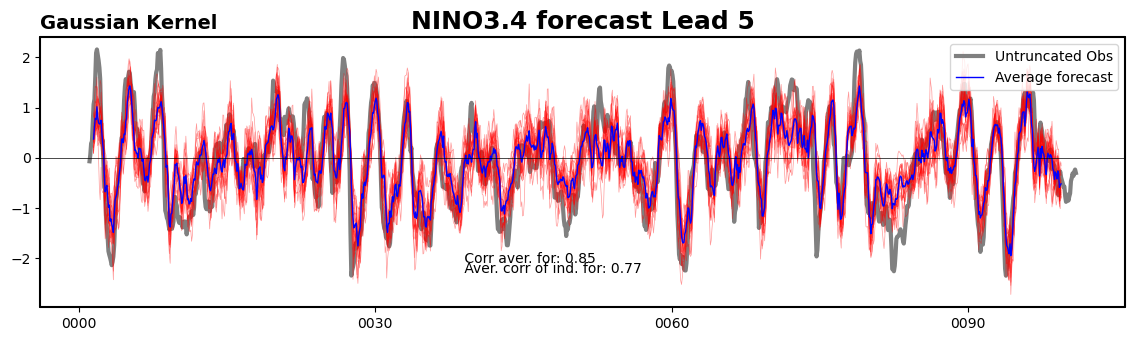

0.8129338163959741
0.7047636085082424
0.39080616418615255
0.284330923099932


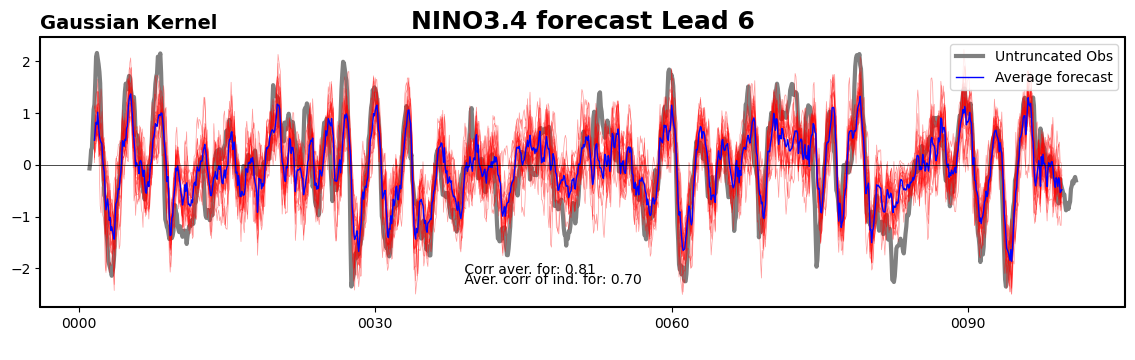

0.772795694755216
0.6423983160249002
0.34017403347552033
0.22326295897872406


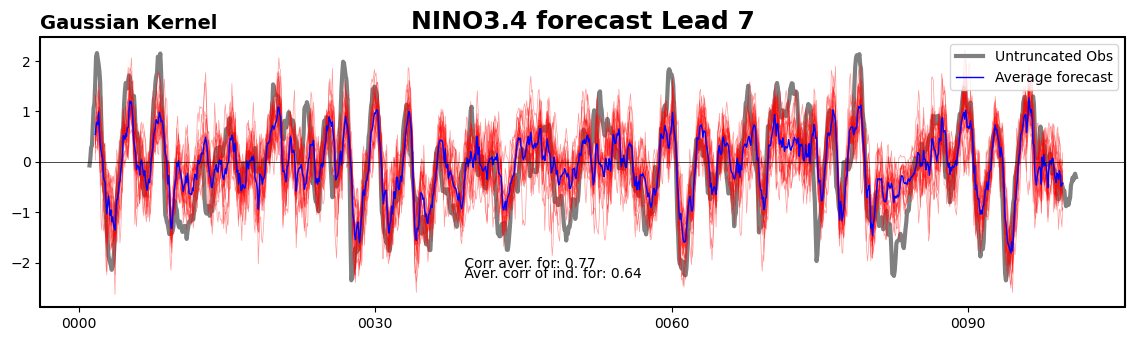

0.7306457781901465
0.5837078613558555
0.2958832203355911
0.17086431560677862


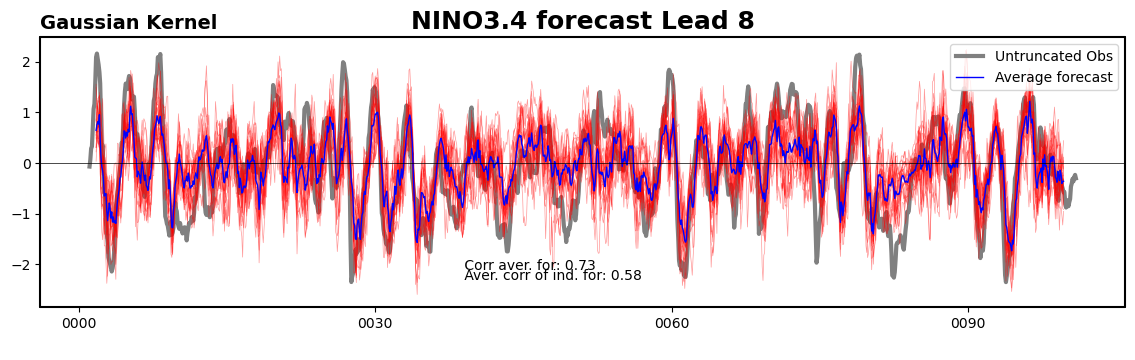

0.6838279307492873
0.5223860068782173
0.25219483587867175
0.11954411213994605


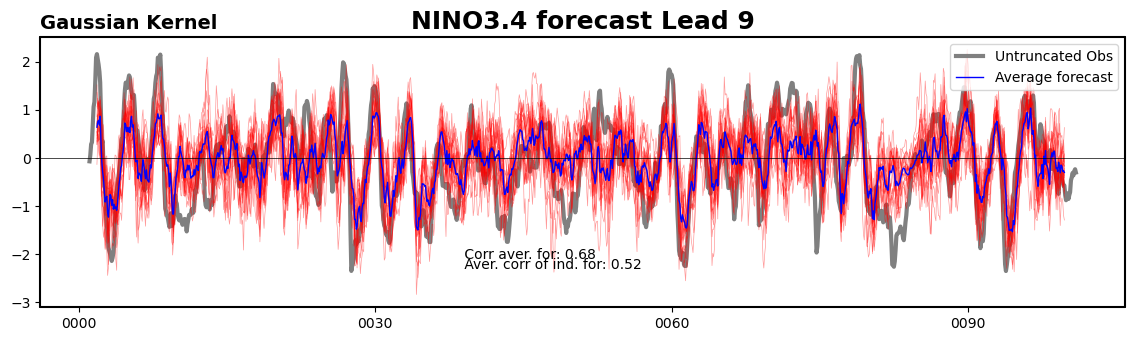

0.6303451970824376
0.4668815290133762
0.21072611164795063
0.07627971000794638


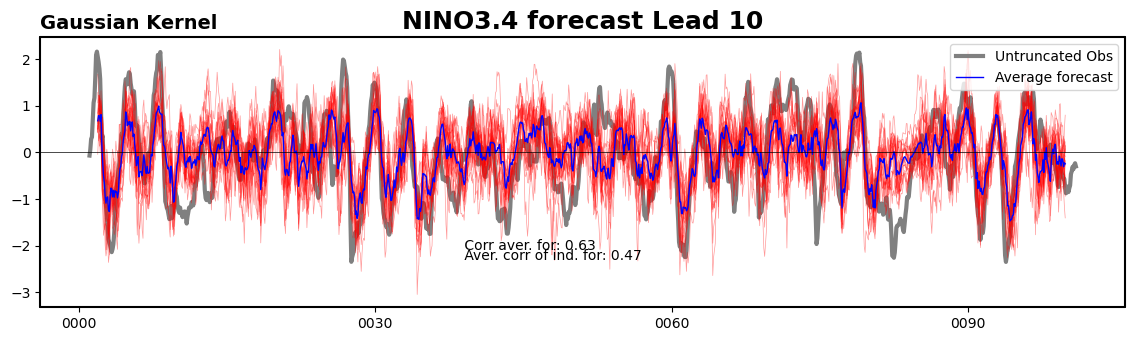

0.5862017208885654
0.4180259055194265
0.17880846163197994
0.04050737213528874


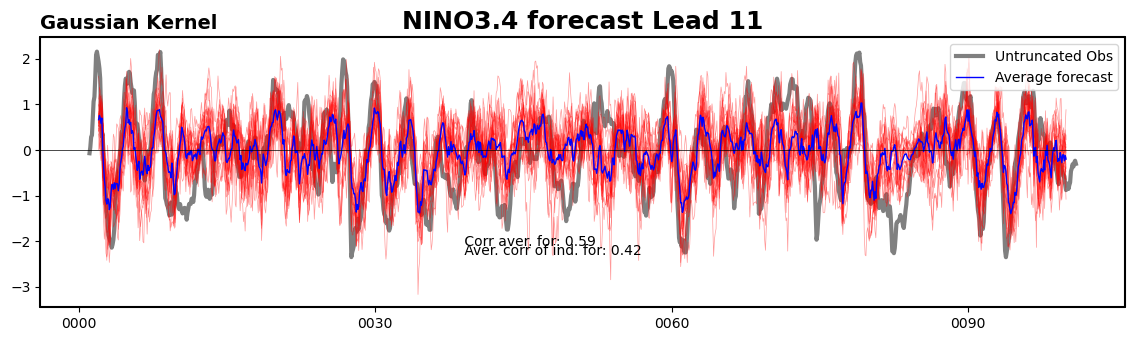

0.5401638793653899
0.3714876998420882
0.14844056212936907
0.008500704981104959


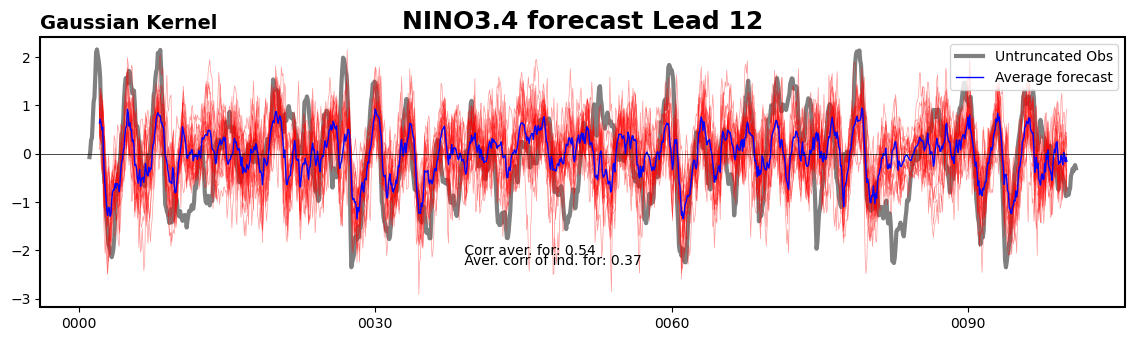

0.49945276793589033
0.33794267135205974
0.12465906234885105
-0.014689570943475649


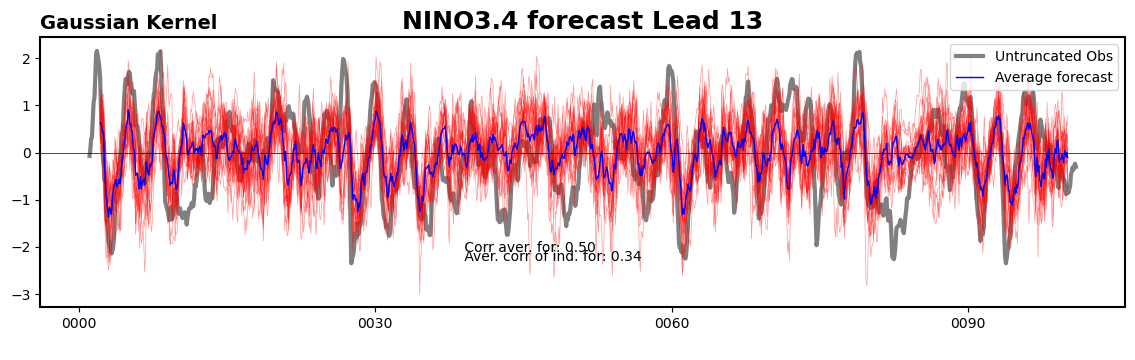

0.4598214967734708
0.30492636795034433
0.1041828137889158
-0.035014444649276305


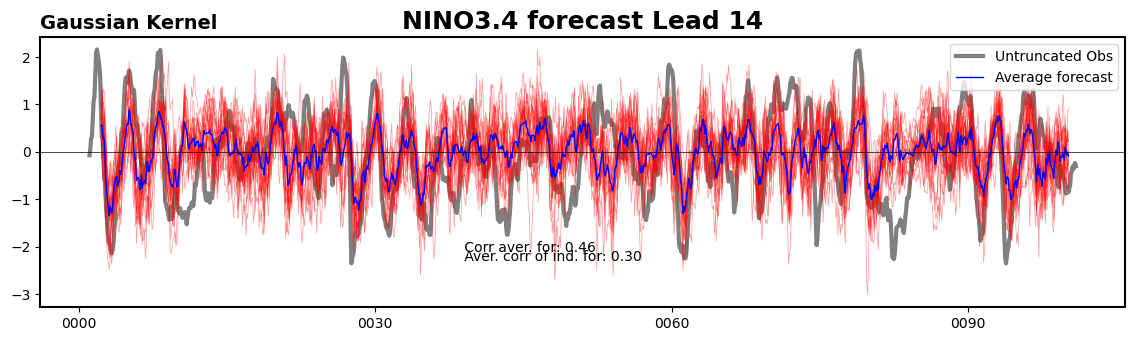

0.41482633116458445
0.26705626750765515
0.0813108433127534
-0.0579022700905841


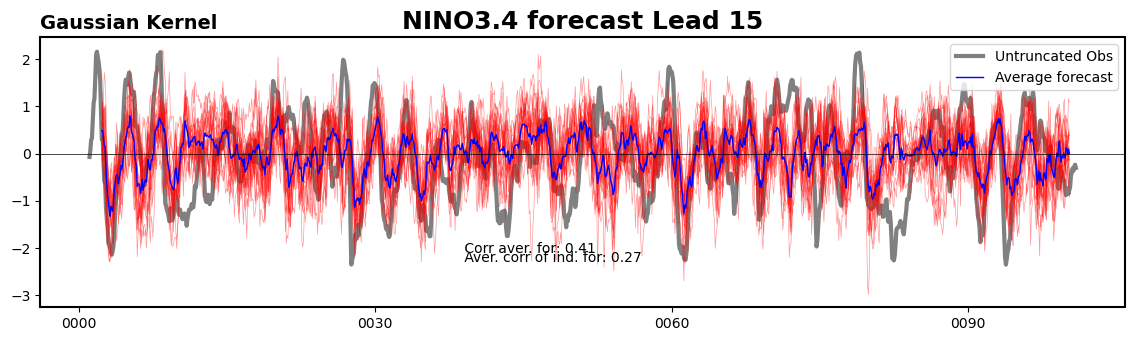

0.3837923843599144
0.23799277456784526
0.06710602657350517
-0.073192924716414


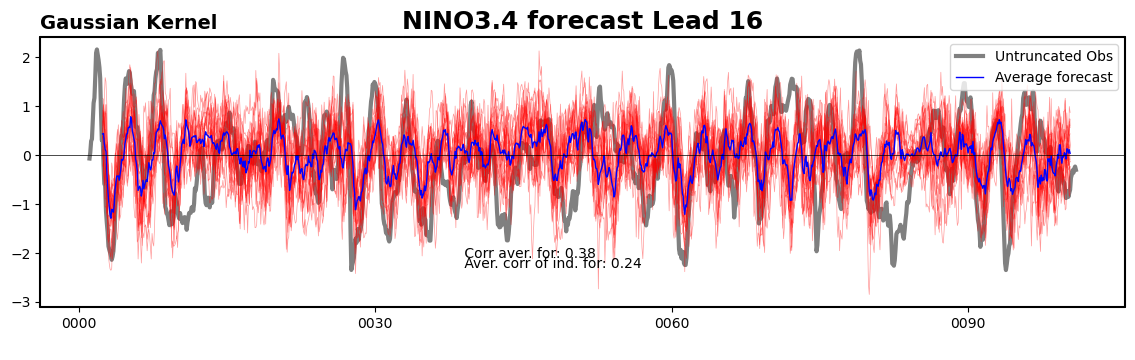

0.34004302555974775
0.2025306115169525
0.048469554467323483
-0.09542137068573638


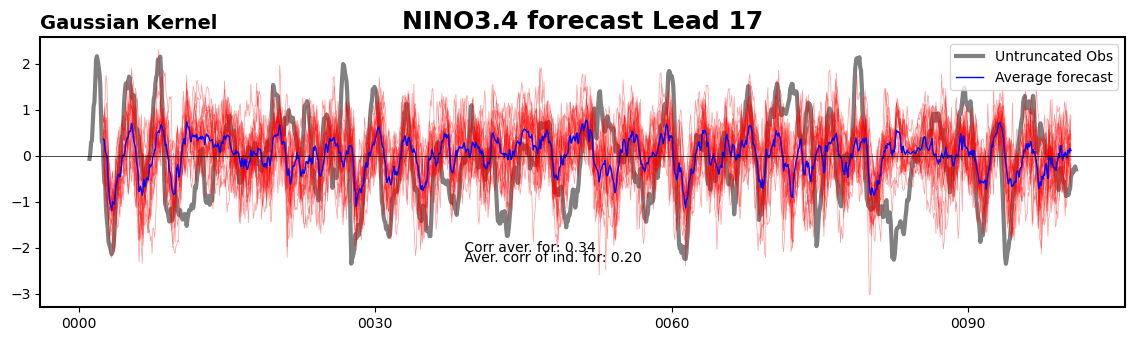

0.30488784180945
0.17479934616804335
0.03437679747318334
-0.11221838077531077


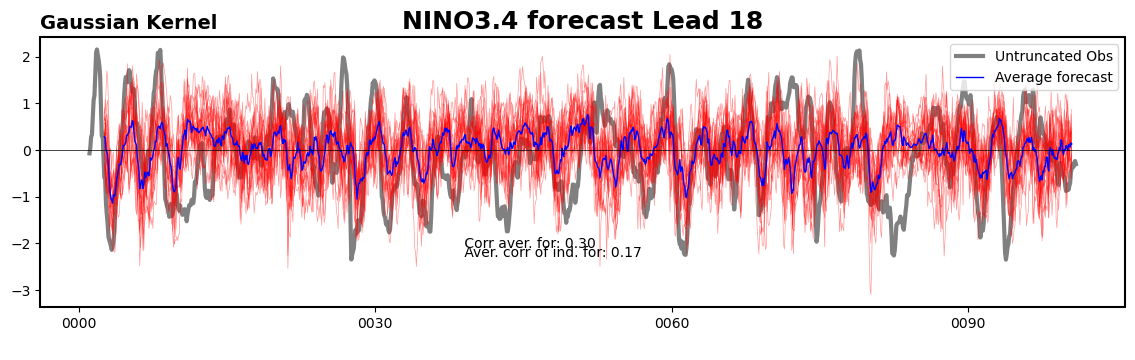

0.2749058428326556
0.15085273336268704
0.02488843677785424
-0.12504203625436525


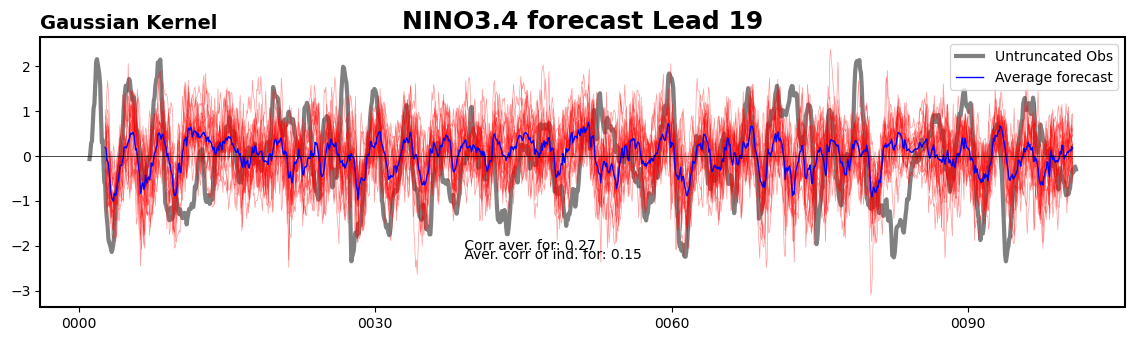

0.24385693708178946
0.1291408458313594
0.013647325797851106
-0.1397384971876009


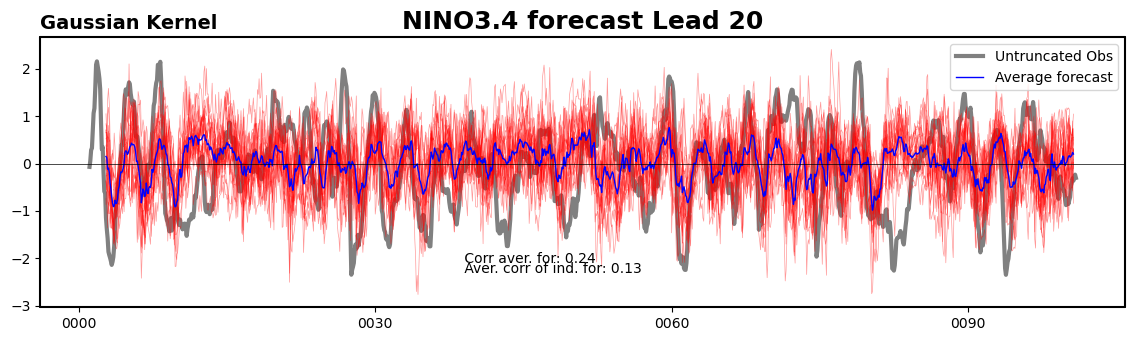

0.22121318892342767
0.11107995567073664
0.006720030475780847
-0.15176818610524384


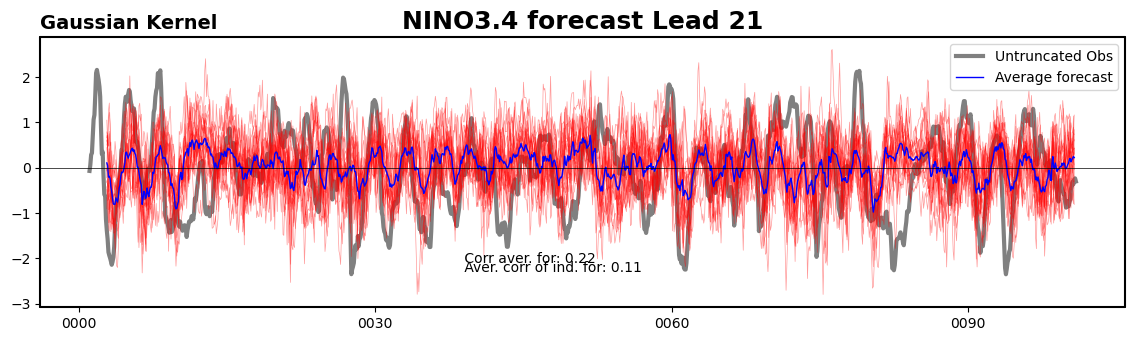

0.20379738534296615
0.09911111253949893
0.0030411529520995018
-0.16046671913709232


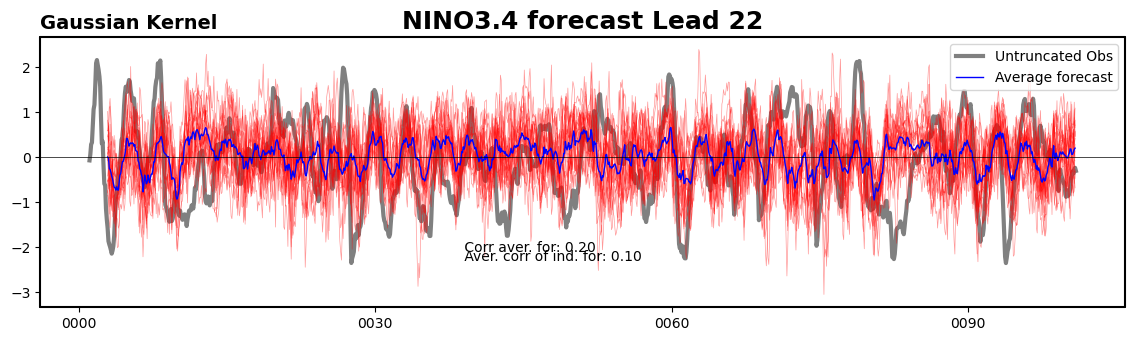

0.19584815305143566
0.09150669221461132
0.0025704373751200826
-0.16574980149106885


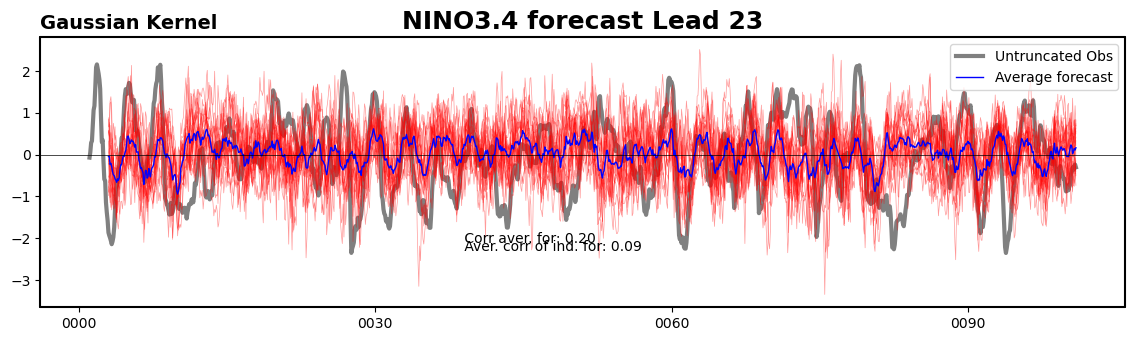

In [41]:
for n in lead_times:

    lead=n

    '''## Compute observations truncated to PCs
    x_pcs_array=udat_sst @ PCs[0:1000,:]
    x_pcs=xr.full_like(X_tos_sel,0)
    x_pcs.data=x_pcs_array
    XindexPCs=x_pcs.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))[:-1]'''

    ## Compute average forecast
    av_for=np.mean(tot_for, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
    av_for_geo.data=av_for_geo_array.real
    Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Correlation average forecast and observations
    mean_av[lead]=np.corrcoef(Xindex[0+lead:1176+lead],Avindex)[0,1]
    print(mean_av[lead])

    #Average correlation between individual forecast and observations
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        mean_ind[lead,i]=np.corrcoef(Xindex[0+lead:1176+lead],Phiindex)[0,1]

    av_corr=np.mean(mean_ind, axis=1)[lead]
    print(av_corr)
    

    #JAKOB RMSE average forecast and observations
    Jrmse_mean_av[lead]=1-np.sqrt(np.square(np.subtract(Xindex[0+lead:1176+lead],Avindex)).mean()) / np.std(Xindex[0+lead:1190+lead])
    print(Jrmse_mean_av[lead])

    #Average error between individual forecast and observations

    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        Jrmse_mean_ind[lead,i]= 1-np.sqrt(np.square(np.subtract(Xindex[0+lead:1176+lead],Phiindex)).mean()) / np.std(Xindex[0+lead:1190+lead])


    Jav_rmse=np.mean(Jrmse_mean_ind, axis=1)[lead]
    print(Jav_rmse)
    
    #Plot
    import nc_time_axis

    fig, ax = plt.subplots(1, 1, figsize=(14,3.5),squeeze=False)

    #XindexPCs.plot(label='Obs data (PCs)',lw=3,color='gray')
    Xindex.plot(label='Untruncated Obs',lw=3,color='gray')

    for i in for_levels:  
        #Expand forecast to geographical domain
        phix_geo_array=udat_sst @ tot_for[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real

        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        Phiindex.plot(lw=0.5, color='red', alpha=0.4)

    Avindex.plot(label='Average forecast',lw=1,color='blue')

    plt.axhline(0,color='black',lw=0.5)
    plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
    plt.title(f'Gaussian Kernel',loc='left',**flabel)
    plt.xlabel(' ')
    plt.legend(loc='upper right')
    zmap.changebox(plt.gca(),'all',linewidth=1.5)
    #loctime = Xindex.sel(time='1-JAN-2000').time.data
    cstr1 = f' Corr aver. for: {mean_av[lead]:>.2f}'
    cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
    loctime = Xindex.isel(time=450).time.data
    plt.text(loctime,-2.1,cstr1)
    plt.text(loctime,-2.3,cstr2)
    #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
    #plt.savefig(labfile, orientation='landscape',  format='pdf')
    plt.show()


## Overall Plot

In [42]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

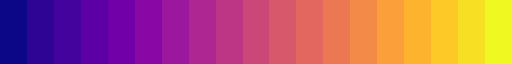

In [43]:
cmap   # First forecasts purple,    last forecasts yellow

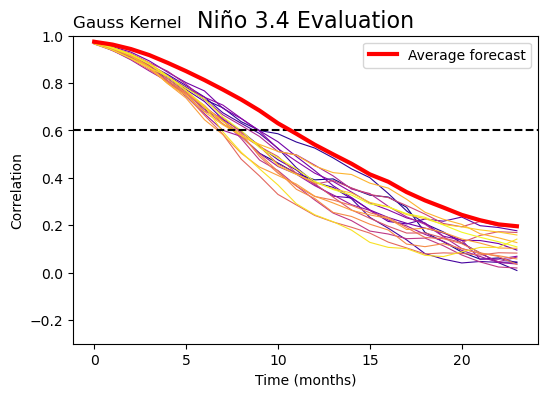

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))

xval=range(0,24)
for i in for_levels:  
    
    val=mean_ind[:,i]
    ax.plot(xval,val, color= color_list[i], lw=0.8)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Correlation')
ax.set_ylim([-0.3,1.0])
ax.set_title('Gauss Kernel',loc='left')

ax.plot(xval, mean_av, color='red', lw=3, label='Average forecast')


bigtitle = 'Niño 3.4 Evaluation' 
ax.set_title(bigtitle,fontsize=16)

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

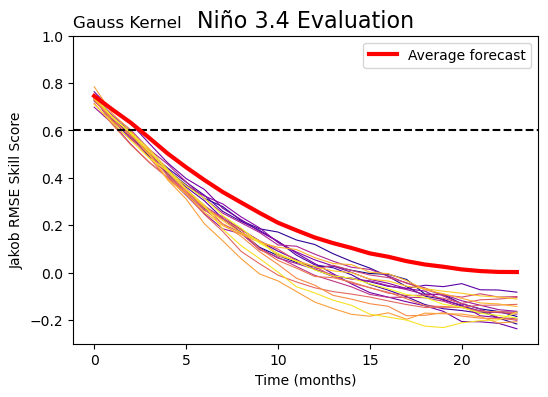

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))

xval=range(0,24)

for i in for_levels:  
    
    val=Jrmse_mean_ind[:,i]
    ax.plot(xval,val, color= color_list[i], lw=0.8)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Jakob RMSE Skill Score')
ax.set_ylim([-0.3,1.0])
ax.set_title('Gauss Kernel',loc='left')

ax.plot(xval, Jrmse_mean_av, color='red', lw=3, label='Average forecast')

bigtitle = 'Niño 3.4 Evaluation' 
ax.set_title(bigtitle,fontsize=16)

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show()